In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 25s 316ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675 - val_loss: 0.1568 - val_root_mean_squared_error: 0.3960
Epoch 2/50
53/53 [==============================] - 16s 308ms/step - loss: 0.0667 - root_mean_squared_error: 0.2584 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2525
Epoch 3/50
53/53 [==============================] - 16s 299ms/step - loss: 0.0480 - root_mean_squared_error: 0.2190 - val_loss: 0.0581 - val_root_mean_squared_error: 0.2410
Epoch 4/50
53/53 [==============================] - 16s 308ms/step - loss: 0.0431 - root_mean_squared_error: 0.2076 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2290
Epoch 5/50
53/53 [==============================] - 16s 313ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2139
Epoch 6/50
53/53 [==============================] - 18s 345ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830 - val_loss: 0.0389 

53/53 [==============================] - 18s 341ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 28/50
53/53 [==============================] - 17s 331ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 29/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 30/50
53/53 [==============================] - 17s 328ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 31/50
53/53 [==============================] - 17s 326ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 32/50
53/53 [==============================] - 3s 51ms/step - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0115 - val_root

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

11.767335128784179 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

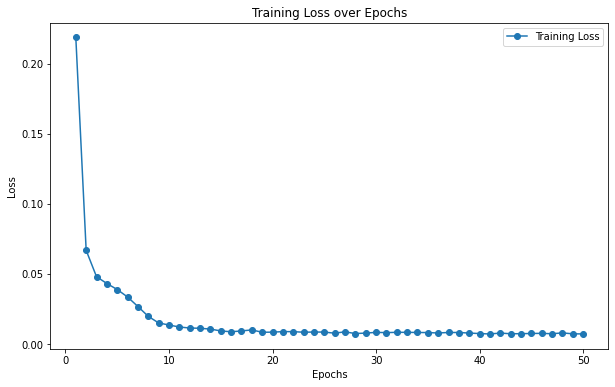

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

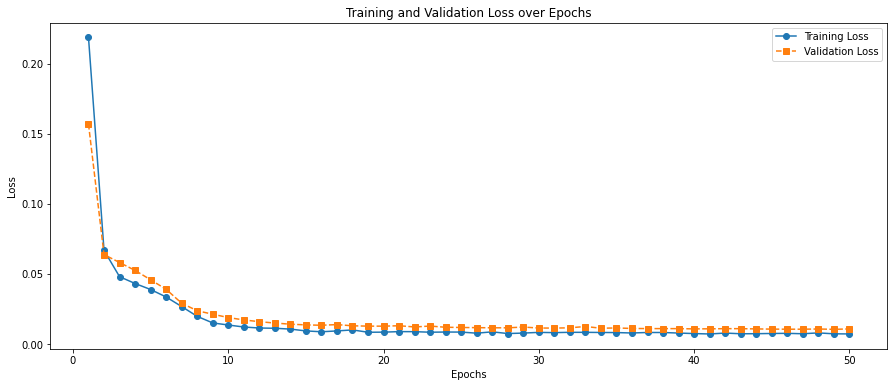

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 33ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08387052872509485
MAE : 0.06790293646082053


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.306457e+06,1202791.069
1,7.199288e+05,752834.272
2,3.847016e+05,451914.219
3,3.837645e+05,439855.813
4,6.998351e+05,807857.307
5,1.120949e+06,1184280.145
6,1.519710e+06,1468308.405
7,1.865180e+06,1540851.607
8,2.087042e+06,1989099.836
9,2.109107e+06,2096990.761


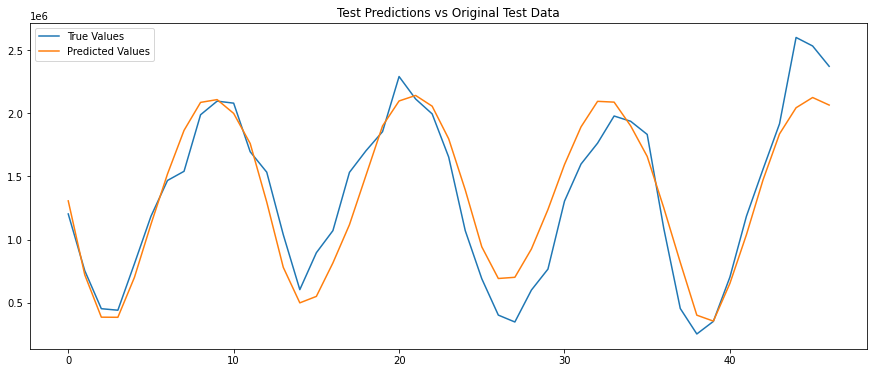

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 22ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

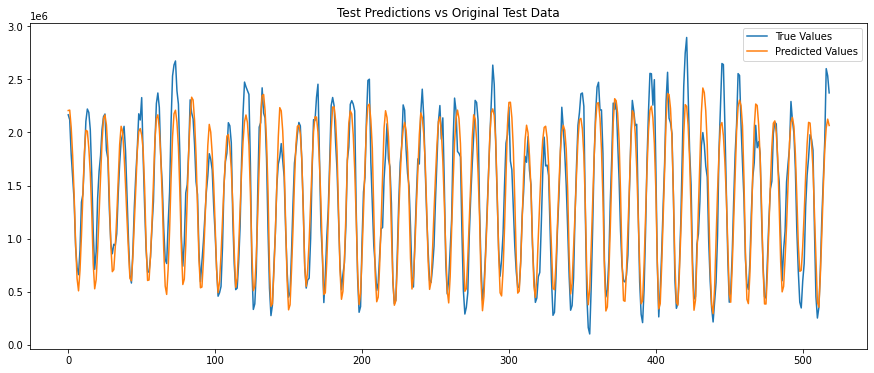

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()